# Regressão

Agora, com os nossos dados, queremos estimar a peak position (posição mais alta alcançada pela música) nos baseando nos atributos que já temos.

In [1]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

songs = pd.read_csv('../dataset/songs_one_hot_encoding.csv',
                 encoding='iso-8859-1', na_values='unknown')
songs.head()

,date,title,artist,peak_pos,pop,dance pop,pop rap,rap,post-teen pop,hip hop,...,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode
0,6/21/18,all girls are the same,juice wrld,41,0,0,0,1,0,0,...,0.3070,0.0769,0.000335,4.0,0.671,0.0,165820.0,-7.226,0.203,1.0
1,6/21/18,all mine,kanye west,11,0,0,1,1,0,0,...,0.3380,0.1250,0.000000,4.0,0.925,11.0,145507.0,-6.562,0.265,0.0
2,6/21/18,back to you,selena gomez,22,1,1,0,0,1,0,...,0.0486,0.0945,0.000002,4.0,0.601,6.0,207905.0,-4.856,0.508,1.0
3,6/21/18,be careful,cardi b,11,1,0,0,1,0,0,...,0.4110,0.0256,0.000000,4.0,0.820,6.0,210787.0,-8.230,0.535,0.0
4,6/21/18,beautiful crazy,luke combs,58,0,0,0,0,0,0,...,0.0262,0.6760,0.000000,4.0,0.552,11.0,193200.0,-7.431,0.382,1.0


Vamos remover o título da música, que não será relevante para a regressão, e a coluna de gêneros, já que já realizamos o one-hot encoding dos gêneros mais relevantes.

Por experimentação, definimos também que a duração da música não é interessante para a regressão.

In [2]:
songs = songs.drop(['title', 'genre', 'artist', 'duration_ms'], axis=1)
songs.head()

,date,peak_pos,pop,dance pop,pop rap,rap,post-teen pop,hip hop,r&b,contemporary country,...,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,loudness,valence,mode
0,6/21/18,41,0,0,0,1,0,0,0,0,...,161.989,0.3070,0.0769,0.000335,4.0,0.671,0.0,-7.226,0.203,1.0
1,6/21/18,11,0,0,1,1,0,0,0,0,...,122.099,0.3380,0.1250,0.000000,4.0,0.925,11.0,-6.562,0.265,0.0
2,6/21/18,22,1,1,0,0,1,0,0,0,...,102.061,0.0486,0.0945,0.000002,4.0,0.601,6.0,-4.856,0.508,1.0
3,6/21/18,11,1,0,0,1,0,0,0,0,...,152.279,0.4110,0.0256,0.000000,4.0,0.820,6.0,-8.230,0.535,0.0
4,6/21/18,58,0,0,0,0,0,0,0,1,...,103.313,0.0262,0.6760,0.000000,4.0,0.552,11.0,-7.431,0.382,1.0


Também precisamos transformar a data em algo que o algoritmo de regressão entenderá.

In [3]:
songs['date'] = pd.to_datetime(songs['date'], format='%m/%d/%y')
songs['date'] = songs['date'].map(dt.datetime.toordinal)
songs.head()

,date,peak_pos,pop,dance pop,pop rap,rap,post-teen pop,hip hop,r&b,contemporary country,...,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,loudness,valence,mode
0,736866,41,0,0,0,1,0,0,0,0,...,161.989,0.3070,0.0769,0.000335,4.0,0.671,0.0,-7.226,0.203,1.0
1,736866,11,0,0,1,1,0,0,0,0,...,122.099,0.3380,0.1250,0.000000,4.0,0.925,11.0,-6.562,0.265,0.0
2,736866,22,1,1,0,0,1,0,0,0,...,102.061,0.0486,0.0945,0.000002,4.0,0.601,6.0,-4.856,0.508,1.0
3,736866,11,1,0,0,1,0,0,0,0,...,152.279,0.4110,0.0256,0.000000,4.0,0.820,6.0,-8.230,0.535,0.0
4,736866,58,0,0,0,0,0,0,0,1,...,103.313,0.0262,0.6760,0.000000,4.0,0.552,11.0,-7.431,0.382,1.0


Como são muitas posições possíveis, vamos separar em categorias: entre 1 e 20, 21 e 80, e 81 até 100.

In [4]:
def classifier(pos):
    if (pos < 21):
        return 0
    if (pos < 81):
        return 1
    return 2

songs['peak_pos'] = list(map(classifier, songs['peak_pos']))
songs.head()

,date,peak_pos,pop,dance pop,pop rap,rap,post-teen pop,hip hop,r&b,contemporary country,...,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,loudness,valence,mode
0,736866,1,0,0,0,1,0,0,0,0,...,161.989,0.3070,0.0769,0.000335,4.0,0.671,0.0,-7.226,0.203,1.0
1,736866,0,0,0,1,1,0,0,0,0,...,122.099,0.3380,0.1250,0.000000,4.0,0.925,11.0,-6.562,0.265,0.0
2,736866,1,1,1,0,0,1,0,0,0,...,102.061,0.0486,0.0945,0.000002,4.0,0.601,6.0,-4.856,0.508,1.0
3,736866,0,1,0,0,1,0,0,0,0,...,152.279,0.4110,0.0256,0.000000,4.0,0.820,6.0,-8.230,0.535,0.0
4,736866,1,0,0,0,0,0,0,0,1,...,103.313,0.0262,0.6760,0.000000,4.0,0.552,11.0,-7.431,0.382,1.0


Agora vamos separar nossos dados de treino e teste.

In [5]:
train, test = train_test_split(songs, test_size=0.10)

Y_train = train[['peak_pos']]
Y_test = test[['peak_pos']]

X_train = train.drop(['peak_pos'], axis=1)
X_test = test.drop(['peak_pos'], axis=1)

In [6]:
model = LogisticRegressionCV(Cs=100,
                             penalty='l2',   
                             cv=5,           
                             fit_intercept=False,
                             multi_class='ovr')

model.fit(X_train, Y_train.values.ravel())
result_regression = model.predict(X_test)

In [7]:
print(classification_report(Y_test, result_regression))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       170
           1       0.78      0.88      0.82       397
           2       0.82      0.53      0.64       134

   micro avg       0.79      0.79      0.79       701
   macro avg       0.80      0.73      0.75       701
weighted avg       0.79      0.79      0.78       701



In [8]:
print(accuracy_score(Y_test, result_regression))

0.7860199714693296


([<matplotlib.axis.YTick at 0x1f493637358>,
 <a list of 3 Text yticklabel objects>)

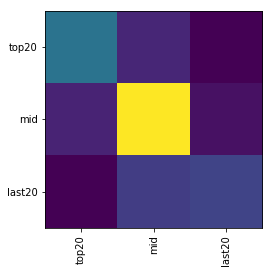

In [9]:
index = [0,1,2]
labels = ['top20', 'mid', 'last20']

plt.imshow(confusion_matrix(Y_test, result_regression))
plt.xticks(index, labels, rotation=90)
plt.yticks(index, labels)

Assim, conseguimos resultados satisfatórios com a regressão para definir a posição da música no top 100 da Billboard, com acurácia de cerca de 78%.